In [1]:
from GSSFiltering.model import SyntheticNLModel
from GSSFiltering.filtering import Extended_Kalman_Filter
from GSSFiltering.filtering import KalmanNet_Filter, Split_KalmanNet_Filter, KalmanNet_Filter_v2
from GSSFiltering.filtering import Cholesky_KalmanNet_Filter
from GSSFiltering.trainer import Trainer
from GSSFiltering.tester import Tester
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import configparser
import os

if not os.path.exists('./.results'):
    os.mkdir('./.results')

config = configparser.ConfigParser()
config.read('./config.ini')

['./config.ini']

In [2]:
Gen_data = False
Train = False

In [3]:
if Gen_data:
    SyntheticNLModel(mode='train').generate_data()
    SyntheticNLModel(mode='valid').generate_data()
    SyntheticNLModel(mode='test').generate_data()
    SyntheticNLModel(mode='test_filter').generate_data()

In [4]:
train_iter = int(config['Train']['train_iter'])

test_list = [config['Train']['train_iter']]
# test_list = ['best']

loss_list_Kalman = []
loss_list_Split_Kalman = []
loss_list_CKN = []
loss_list_Kalman_cov = []
loss_ekf = []

valid_loss_Kalman = []
valid_loss_Split_Kalman = []
valid_loss_CKN = []
valid_loss_Kalman_cov = []

test_loss_ekf = []
test_loss_Kalman = []
test_loss_Split_Kalman = []
test_loss_CKN = []
test_loss_Kalman_cov = []

lambda1_history = []


if Train:
    # KalmanNet
    trainer_kalman = Trainer(
        dnn=KalmanNet_Filter(
            SyntheticNLModel(mode='train')), 
        data_path='./.data/SyntheticNL/train/', 
        save_path='(SyntheticNL) KalmanNet.pt',
        mode=0)
    
    trainer_skn = Trainer(
        dnn=Split_KalmanNet_Filter(
            SyntheticNLModel(mode='train')), 
        data_path='./.data/SyntheticNL/train/', 
        save_path='(SyntheticNL) Split-KalmanNet.pt',
        mode=1)
    
    trainer_ckn = Trainer(
        dnn=Cholesky_KalmanNet_Filter(
            SyntheticNLModel(mode='train')), 
        data_path='./.data/SyntheticNL/train/', 
        save_path='(SyntheticNL) Cholesky-KalmanNet.pt',
        mode=1)
    
    for i in range(train_iter):
        trainer_kalman.train_batch()
        trainer_kalman.dnn.reset(clean_history=True)    
        if trainer_kalman.train_count % trainer_kalman.save_num == 0:
            trainer_kalman.validate(
                Tester(
                        filter = KalmanNet_Filter(
                            SyntheticNLModel(mode='valid')), 
                        data_path = './.data/SyntheticNL/valid/',
                        model_path = './.model_saved/(SyntheticNL) KalmanNet_' + str(trainer_kalman.train_count) + '.pt',
                        is_validation=True
                        )    
            )
        loss_list_Kalman += [trainer_kalman.train_loss.item()] # [dB]

        trainer_skn.train_batch()
        trainer_skn.dnn.reset(clean_history=True)    
        if trainer_skn.train_count % trainer_skn.save_num == 0:
            trainer_skn.validate(
                Tester(
                        filter = Split_KalmanNet_Filter(
                            SyntheticNLModel(mode='valid')), 
                        data_path = './.data/SyntheticNL/valid/',
                        model_path = './.model_saved/(SyntheticNL) Split-KalmanNet_' + str(trainer_skn.train_count) + '.pt',
                        is_validation=True
                        )    
            )
        loss_list_Split_Kalman += [trainer_skn.train_loss.item()] # [dB]    


        trainer_ckn.train_batch()
        trainer_ckn.dnn.reset(clean_history=True)    
        if trainer_ckn.train_count % trainer_ckn.save_num == 0:
            trainer_ckn.validate(
                Tester(
                        filter = Cholesky_KalmanNet_Filter(
                            SyntheticNLModel(mode='valid')), 
                        data_path = './.data/SyntheticNL/valid/',
                        model_path = './.model_saved/(SyntheticNL) Cholesky-KalmanNet_' + str(trainer_ckn.train_count) + '.pt',
                        is_validation=False
                        )    
            )
        loss_list_CKN += [trainer_ckn.train_loss.item()] # [dB]

    np.save('./.results/train_loss_kn.npy', np.array(loss_list_Kalman))
    np.save('./.results/train_loss_skn.npy', np.array(loss_list_Split_Kalman))
    np.save('./.results/train_loss_ckn.npy', np.array(loss_list_CKN))

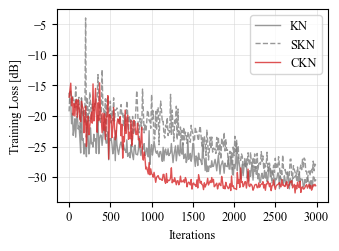

In [5]:
# Configuration for font and style
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.size'] = 9

fontsize = 9
labelsize = fontsize
linewidth = 1

# x = np.arange(x1, x2+1, x1)

# selection = np.arange(0, x.shape[0], 1)

loss_kn = np.load('./.results/train_loss_kn.npy')
loss_skn = np.load('./.results/train_loss_skn.npy')
loss_ckn = np.load('./.results/train_loss_ckn.npy')

# Calculate indices for plotting every 50 points
x_kn = np.arange(0, loss_kn.shape[0], 10)
x_skn = np.arange(0, loss_skn.shape[0], 10)
x_ckn = np.arange(0, loss_ckn.shape[0], 10)

# Subsample the data
loss_kn_subsampled = loss_kn[x_kn]
loss_skn_subsampled = loss_skn[x_skn]
loss_ckn_subsampled = loss_ckn[x_ckn]

# Create the plot
fig, ax = plt.subplots(figsize=(3.5, 2.5))  # Specify figure size

ax.plot(x_kn, 10*np.log10(loss_kn_subsampled), 
        label='KN', 
        linewidth=linewidth, 
        color='tab:gray',  # Consistent color for KN
        linestyle='solid',
        alpha = 0.8)

ax.plot(x_skn, 10*np.log10(loss_skn_subsampled), 
        label='SKN', 
        linewidth=linewidth, 
        color='tab:gray',  # Consistent color for SKN
        linestyle='dashed',
        alpha=0.8)

ax.plot(x_ckn, 10*np.log10(loss_ckn_subsampled), 
        label='CKN', 
        linewidth=linewidth, 
        color='tab:red',  
        linestyle='solid',
        alpha=0.8)

ax.set_xlabel('Iterations', fontsize=fontsize)
ax.set_ylabel('Training Loss [dB]', fontsize=fontsize)
ax.legend(loc='upper right', fontsize=fontsize)
ax.grid(True, which='both', linestyle='-', linewidth=0.5, color='lightgray', alpha=0.7)  # Brighter grid lines
plt.savefig('ex2_learning_curve.png', dpi=500, bbox_inches='tight')

plt.show()

In [6]:
ground_truth =torch.load('./.data/SyntheticNL/test_filter/ground_truth.pt')
state = torch.load('./.data/SyntheticNL/test_filter/state.pt')
measurement = torch.load('./.data/SyntheticNL/test_filter/obs.pt')


C:\Users\minhy\AppData\Local\Temp\ipykernel_39284\735488248.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ground_truth =torch.load('./.data/SyntheticNL/test_filter/gro

## Newly trained model

In [ ]:
# test_list = ['best']


# filter_loss_list_KN = []
# filter_loss_list_SKN = []
# filter_loss_list_ckn = []

# tester_ekf = Tester(
#             filter = Extended_Kalman_Filter(
#                 SyntheticNLModel(mode='test')), 
#             data_path = './.data/SyntheticNL/test_filter/',
#             model_path = 'EKF'
#             )   
# rms_ekf = [tester_ekf.loss.item()]

# for elem in test_list:
#     tester_kn = Tester(
#                 filter = KalmanNet_Filter(
#                     SyntheticNLModel(mode='test')), 
#                 data_path = './.data/SyntheticNL/test_filter/',
#                 model_path = './.model_saved/(SyntheticNL) KalmanNet_'+elem+'.pt'
#                 )
#     filter_loss_list_KN += [tester_kn.loss.item()]

#     tester_skn = Tester(
#                 filter = Split_KalmanNet_Filter(
#                     SyntheticNLModel(mode='test')), 
#                 data_path = './.data/SyntheticNL/test_filter/',
#                 model_path = './.model_saved/(SyntheticNL) Split-KalmanNet_'+elem+'.pt'
#                 )
#     filter_loss_list_SKN += [tester_skn.loss.item()]

#     tester_ckn = Tester(
#                 filter = Cholesky_KalmanNet_Filter(
#                     SyntheticNLModel(mode='test')), 
#                 data_path = './.data/SyntheticNL/test_filter/',
#                 model_path = './.model_saved/(SyntheticNL) Cholesky-KalmanNet_'+elem+'.pt'
#                 )
#     filter_loss_list_ckn += [tester_ckn.loss.item()]

# print(filter_loss_list_KN)
# print(filter_loss_list_SKN)
# print(filter_loss_list_ckn)

c:\Users\minhy\OneDrive - The Ohio State University\01_OSU\02_research\02_kalmannet\03_paper\01_Chol_KN\ckn_defense_signalprocessletter\CKN_github\GSSFiltering\tester.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any 

Testing 0 / 300 of EKF
Testing 25 / 300 of EKF
Testing 50 / 300 of EKF
Testing 75 / 300 of EKF
Testing 100 / 300 of EKF
Testing 125 / 300 of EKF
Testing 150 / 300 of EKF
Testing 175 / 300 of EKF
Testing 200 / 300 of EKF
Testing 225 / 300 of EKF
Testing 250 / 300 of EKF
Testing 275 / 300 of EKF
loss = 0.1700
Testing 0 / 300 of ./.model_saved/(SyntheticNL) KalmanNet_best.pt


c:\Users\minhy\OneDrive - The Ohio State University\01_OSU\02_research\02_kalmannet\03_paper\01_Chol_KN\ckn_defense_signalprocessletter\CKN_github\GSSFiltering\tester.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any 

Testing 25 / 300 of ./.model_saved/(SyntheticNL) KalmanNet_best.pt
Testing 50 / 300 of ./.model_saved/(SyntheticNL) KalmanNet_best.pt
Testing 75 / 300 of ./.model_saved/(SyntheticNL) KalmanNet_best.pt
Testing 100 / 300 of ./.model_saved/(SyntheticNL) KalmanNet_best.pt
Testing 125 / 300 of ./.model_saved/(SyntheticNL) KalmanNet_best.pt
Testing 150 / 300 of ./.model_saved/(SyntheticNL) KalmanNet_best.pt
Testing 175 / 300 of ./.model_saved/(SyntheticNL) KalmanNet_best.pt
Testing 200 / 300 of ./.model_saved/(SyntheticNL) KalmanNet_best.pt
Testing 225 / 300 of ./.model_saved/(SyntheticNL) KalmanNet_best.pt
Testing 250 / 300 of ./.model_saved/(SyntheticNL) KalmanNet_best.pt
Testing 275 / 300 of ./.model_saved/(SyntheticNL) KalmanNet_best.pt
loss = 0.1066
Testing 0 / 300 of ./.model_saved/(SyntheticNL) Split-KalmanNet_best.pt
Testing 25 / 300 of ./.model_saved/(SyntheticNL) Split-KalmanNet_best.pt
Testing 50 / 300 of ./.model_saved/(SyntheticNL) Split-KalmanNet_best.pt
Testing 75 / 300 of ./.

## For generating same plot in IEEE SPL

In [9]:
filter_loss_list_KN = []
filter_loss_list_SKN = []
filter_loss_list_ckn = []

tester_ekf = Tester(
            filter = Extended_Kalman_Filter(
                SyntheticNLModel(mode='test')), 
            data_path = './.data/SyntheticNL/test_filter/',
            model_path = 'EKF'
            )   
rms_ekf = [tester_ekf.loss.item()]

for elem in test_list:
    tester_kn = Tester(
                filter = KalmanNet_Filter(
                    SyntheticNLModel(mode='test')), 
                data_path = './.data/SyntheticNL/test_filter/',
                model_path = './.model_saved/(SyntheticNL) KalmanNet_saved.pt'
                )
    filter_loss_list_KN += [tester_kn.loss.item()]

    tester_skn = Tester(
                filter = Split_KalmanNet_Filter(
                    SyntheticNLModel(mode='test')), 
                data_path = './.data/SyntheticNL/test_filter/',
                model_path = './.model_saved/(SyntheticNL) Split-KalmanNet_saved.pt'
                )
    filter_loss_list_SKN += [tester_skn.loss.item()]

    tester_ckn = Tester(
                filter = Cholesky_KalmanNet_Filter(
                    SyntheticNLModel(mode='test')), 
                data_path = './.data/SyntheticNL/test_filter/',
                model_path = './.model_saved/(SyntheticNL) Cholesky-KalmanNet_saved.pt'
                )
    filter_loss_list_ckn += [tester_ckn.loss.item()]

print(filter_loss_list_KN)
print(filter_loss_list_SKN)
print(filter_loss_list_ckn)

Testing 0 / 300 of EKF
Testing 25 / 300 of EKF
Testing 50 / 300 of EKF
Testing 75 / 300 of EKF
Testing 100 / 300 of EKF
Testing 125 / 300 of EKF
Testing 150 / 300 of EKF
Testing 175 / 300 of EKF
Testing 200 / 300 of EKF
Testing 225 / 300 of EKF
Testing 250 / 300 of EKF
Testing 275 / 300 of EKF
loss = 0.1700
Testing 0 / 300 of ./.model_saved/(SyntheticNL) KalmanNet_saved.pt
Testing 25 / 300 of ./.model_saved/(SyntheticNL) KalmanNet_saved.pt
Testing 50 / 300 of ./.model_saved/(SyntheticNL) KalmanNet_saved.pt
Testing 75 / 300 of ./.model_saved/(SyntheticNL) KalmanNet_saved.pt
Testing 100 / 300 of ./.model_saved/(SyntheticNL) KalmanNet_saved.pt
Testing 125 / 300 of ./.model_saved/(SyntheticNL) KalmanNet_saved.pt
Testing 150 / 300 of ./.model_saved/(SyntheticNL) KalmanNet_saved.pt
Testing 175 / 300 of ./.model_saved/(SyntheticNL) KalmanNet_saved.pt
Testing 200 / 300 of ./.model_saved/(SyntheticNL) KalmanNet_saved.pt
Testing 225 / 300 of ./.model_saved/(SyntheticNL) KalmanNet_saved.pt
Testin